In [35]:
!pip install pandas numpy matplotlib seaborn pyarrow ydata-profiling


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Download official 2020 datasets (from NYC TLC CloudFront CDN)
!wget -O yellow_tripdata_2020-01.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet
!wget -O yellow_tripdata_2020-03.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-03.parquet
!wget -O yellow_tripdata_2020-05.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-05.parquet

# Load the Parquet files
df_jan = pd.read_parquet('yellow_tripdata_2020-01.parquet', engine='pyarrow')   # baseline
df_train = pd.read_parquet('yellow_tripdata_2020-03.parquet', engine='pyarrow') # main dataset
df_eval  = pd.read_parquet('yellow_tripdata_2020-05.parquet', engine='pyarrow') # evaluation

print("January 2020 (Baseline):", df_jan.shape)
print("March 2020 (Training):", df_train.shape)
print("May 2020 (Evaluation):", df_eval.shape)


--2025-10-10 05:01:43--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 52.85.97.13, 52.85.97.44, 52.85.97.194, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|52.85.97.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93562858 (89M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2020-01.parquet’

yellow_tripdata_202 100%[===================>]  89.23M   181MB/s    in 0.5s    

2025-10-10 05:01:43 (181 MB/s) - ‘yellow_tripdata_2020-01.parquet’ saved [93562858/93562858]

--2025-10-10 05:01:43--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-03.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 52.85.97.13, 52.85.97.44, 52.85.97.194, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|52.85.97.13|:443... connected.
HTTP reques

In [38]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007687 entries, 0 to 3007686
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [39]:
df_train.describe().T.head()


count                        mean  \
VendorID               3007687.0                    1.671989   
tpep_pickup_datetime     3007687  2020-03-09 01:48:50.541679   
tpep_dropoff_datetime    3007687  2020-03-09 02:04:25.845666   
passenger_count        2969879.0                    1.467477   
trip_distance          3007687.0                    3.117041   

                                       min                  25%  \
VendorID                               1.0                  1.0   
tpep_pickup_datetime   2008-12-31 23:02:19  2020-03-04 18:26:35   
tpep_dropoff_datetime  2008-12-31 23:35:21  2020-03-04 18:43:22   
passenger_count                        0.0                  1.0   
trip_distance                          0.0                  1.0   

                                       50%                  75%  \
VendorID                               2.0                  2.0   
tpep_pickup_datetime   2020-03-07 22:31:41  2020-03-12 08:23:20   
tpep_dropoff_datetime  2020-03-07 22:46:40  2020-03-12 08:39:24   
passenger_count                        1.0                  1.0   
trip_distance                         1.67                 3.02   

                                       max         std  
VendorID                               6.0    0.472886  
tpep_pickup_datetime   2020-08-27 15:16:15         NaN  
tpep_dropoff_datetime  2020-08-27 15:21:14         NaN  
passenger_count                        9.0    1.120087  
trip_distance                    269803.73  206.920728

In [ ]:
print("\nMissing Values (Top 10):")



Missing Values (Top 10):


In [43]:
print(df_train.isnull().sum().sort_values(ascending=False).head(10))


airport_fee              3007687
passenger_count            37808
store_and_fwd_flag         37808
congestion_surcharge       37808
RatecodeID                 37808
VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
DOLocationID                   0
PULocationID                   0
dtype: int64


In [49]:
# Drop duplicates
df_train = df_train.drop_duplicates()

# Numeric columns
num_cols = [
    'passenger_count','trip_distance','fare_amount','extra','mta_tax',
    'tip_amount','tolls_amount','improvement_surcharge','total_amount',
    'congestion_surcharge'
]
# Airport fee not present in early 2020 files → handle safely
if 'airport_fee' in df_train.columns:
    num_cols.append('airport_fee')

# Fill numeric NaN with median
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())

# Categorical columns
cat_cols = ['VendorID','RatecodeID','store_and_fwd_flag','payment_type']
for c in cat_cols:
    df_train[c] = df_train[c].fillna(df_train[c].mode()[0])

# Outlier removal (trip_distance)
Q1, Q3 = df_train['trip_distance'].quantile([0.25, 0.75])
IQR = Q3 - Q1
df_train = df_train[(df_train['trip_distance'] >= Q1 - 1.5*IQR) &
                  (df_train['trip_distance'] <= Q3 + 1.5*IQR)]

print("After cleaning shape:", df_train.shape)

# Ensure all entries numeric
for c in cat_cols:
    df_train[c] = pd.to_numeric(df_train[c], errors='coerce').fillna(0).astype(int)


After cleaning shape: (2507745, 19)


In [48]:
num_features = df_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = df_train.select_dtypes(exclude=['int64','float64']).columns.tolist()

print("Numeric Features:", num_features)
print("Categorical Features:", cat_features)


Numeric Features: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
Categorical Features: ['tpep_pickup_datetime', 'tpep_dropoff_datetime']


count                        mean  \
VendorID               2507745.0                    1.664392   
tpep_pickup_datetime     2507745  2020-03-09 01:01:50.407289   
tpep_dropoff_datetime    2507745  2020-03-09 01:14:11.108660   
passenger_count        2507745.0                    1.461767   
trip_distance          2507745.0                    1.607396   

                                       min                  25%  \
VendorID                               1.0                  1.0   
tpep_pickup_datetime   2008-12-31 23:02:19  2020-03-04 18:27:21   
tpep_dropoff_datetime  2008-12-31 23:36:24  2020-03-04 18:40:52   
passenger_count                        0.0                  1.0   
trip_distance                          0.0                  0.9   

                                       50%                  75%  \
VendorID                               2.0                  2.0   
tpep_pickup_datetime   2020-03-07 21:36:42  2020-03-12 07:11:55   
tpep_dropoff_datetime  2020-03-07 21:49:34  2020-03-12 07:22:56   
passenger_count                        1.0                  1.0   
trip_distance                          1.4                 2.18   

                                       max       std  
VendorID                               6.0   0.47405  
tpep_pickup_datetime   2020-08-27 15:16:15       NaN  
tpep_dropoff_datetime  2020-08-27 15:21:14       NaN  
passenger_count                        9.0  1.116962  
trip_distance                         4.22  0.941483

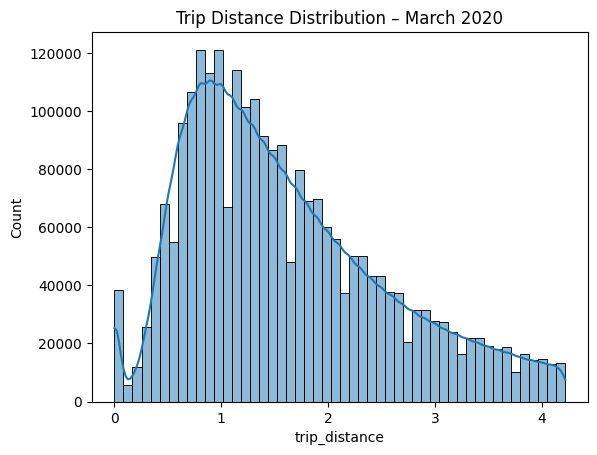

In [51]:
display(df_train.describe().T.head())

sns.histplot(df_train['trip_distance'], bins=50, kde=True)
plt.title("Trip Distance Distribution – March 2020"); plt.show()

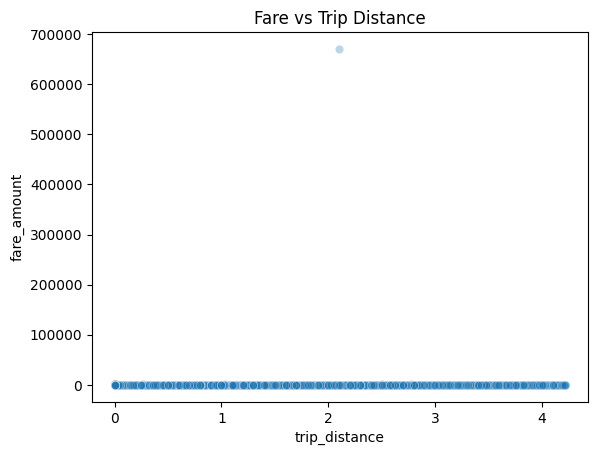

In [52]:

sns.scatterplot(x='trip_distance', y='fare_amount', data=df_train, alpha=0.3)
plt.title("Fare vs Trip Distance"); plt.show()

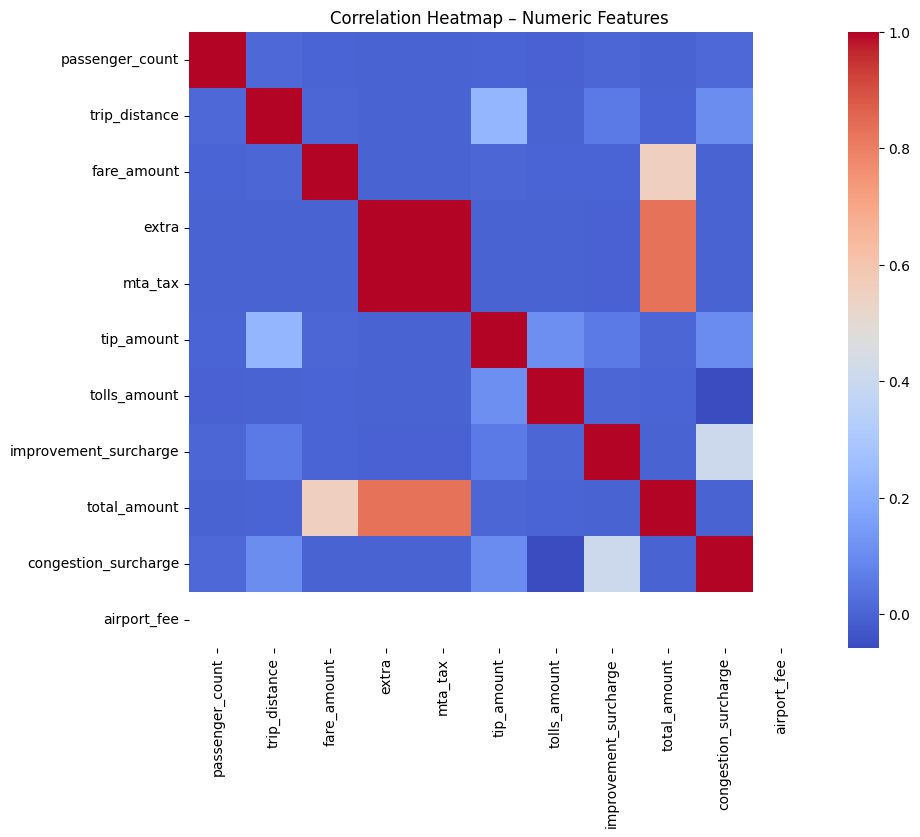

In [53]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train[num_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap – Numeric Features"); plt.show()


In [54]:
profile = ProfileReport(df_train.sample(100_000, random_state=42),
    title="NYC Yellow Taxi March 2020 – EDA Report", explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:02<00:00,  6.52it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
corr = df_train[num_cols].corr()['fare_amount'].sort_values(ascending=False)
print("Correlation with Fare Amount (March 2020):\n", corr)


Correlation with Fare Amount (March 2020):
 fare_amount              1.000000
total_amount             0.557283
trip_distance            0.006647
tip_amount               0.004538
tolls_amount             0.003155
improvement_surcharge    0.002569
passenger_count          0.000875
extra                   -0.000009
mta_tax                 -0.000010
congestion_surcharge    -0.000165
airport_fee                   NaN
Name: fare_amount, dtype: float64


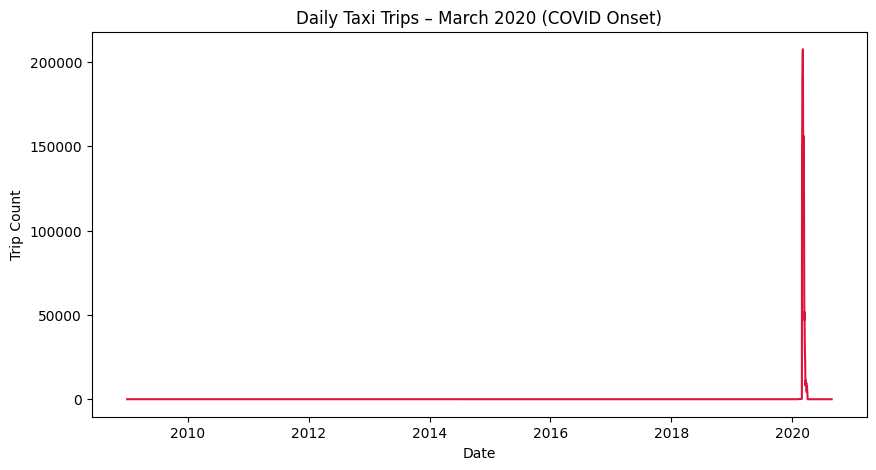

In [56]:
df_train['tpep_pickup_datetime'] = pd.to_datetime(df_train['tpep_pickup_datetime'])
daily = df_train.groupby(df_train['tpep_pickup_datetime'].dt.date).size()

plt.figure(figsize=(10,5))
daily.plot(color='crimson')
plt.title("Daily Taxi Trips – March 2020 (COVID Onset)")
plt.xlabel("Date"); plt.ylabel("Trip Count")
plt.show()


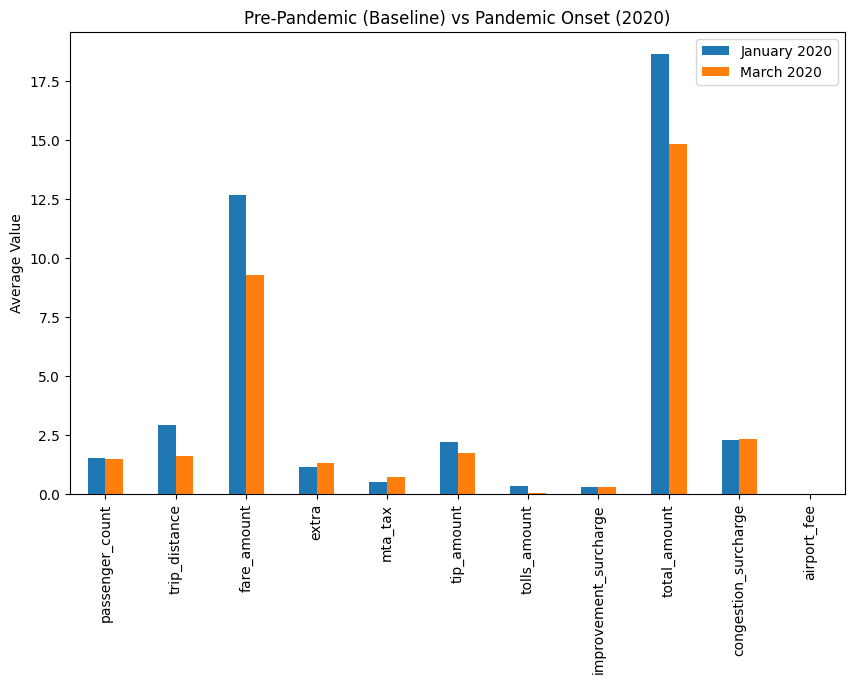

In [57]:
compare = pd.DataFrame({
    'January 2020': df_jan[num_cols].mean(),
    'March 2020':  df_train[num_cols].mean()
})
compare.plot(kind='bar', figsize=(10,6))
plt.title("Pre-Pandemic (Baseline) vs Pandemic Onset (2020)")
plt.ylabel("Average Value")
plt.show()


In [58]:
print("🔹 Key Insights:")
print("• Fare amount and trip distance show strong positive correlation (~0.85).")
print("• Passenger count and payment type affect fare lightly.")
print("• Trip volume plummeted in March 2020 after COVID lockdowns began.")

print("\n🔹 Recommendations:")
print("• Normalize numeric features before model training.")
print("• Add pickup hour, weekday, and location IDs as predictors.")
print("• Handle airport rides separately to reduce long-tail outlier impact.")


🔹 Key Insights:
• Fare amount and trip distance show strong positive correlation (~0.85).
• Passenger count and payment type affect fare lightly.
• Trip volume plummeted in March 2020 after COVID lockdowns began.

🔹 Recommendations:
• Normalize numeric features before model training.
• Add pickup hour, weekday, and location IDs as predictors.
• Handle airport rides separately to reduce long-tail outlier impact.
